In [1]:
import pybnesian as pybn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
SEED = 12312548
CLASS = "Death"
np.random.seed(SEED)

## Prepare dataset

In [2]:
with open('../../Datos/var_sets.json') as f:
    f_vars = json.load(f)
with open('../../Datos/f_sel.json') as f:
    f_sel = json.load(f)
with open('../../Datos/nombres_verbose.json') as f:
    f_verbose = json.load(f)
df = pd.read_csv('../../Datos/FJD_v9-10_1_din.csv')
df.head()

,REGISTRO,Fingplan,Fecha_emision,Fumador,Cardio,Pulmonar,Diabetes,Renal,Neuro,Onco,...,TADprimera,TADMin,TADMax,FCprimera,FCMin,FCMax,TempPrimera,TempMin,TempMax,TiempoIngreso
0,FJD_1,2020-03-22 17:31:12,2020-03-21 18:03:00,Exfumador/a,No,No,Si,No,No,No,...,62.0,47.0,99.0,91.0,34.0,125.0,36.9,35.0,38.8,87.902627
1,FJD_1,2020-03-22 17:31:12,2020-03-23 01:59:00,Exfumador/a,No,No,Si,No,No,No,...,62.0,47.0,99.0,91.0,34.0,125.0,36.9,35.0,38.8,87.902627
2,FJD_1,2020-03-22 17:31:12,2020-03-24 06:44:00,Exfumador/a,No,No,Si,No,No,No,...,62.0,47.0,99.0,91.0,34.0,125.0,36.9,35.0,38.8,87.902627
3,FJD_1,2020-03-22 17:31:12,2020-03-24 18:55:00,Exfumador/a,No,No,Si,No,No,No,...,62.0,47.0,99.0,91.0,34.0,125.0,36.9,35.0,38.8,87.902627
4,FJD_1,2020-03-22 17:31:12,2020-03-25 19:55:00,Exfumador/a,No,No,Si,No,No,No,...,62.0,47.0,99.0,91.0,34.0,125.0,36.9,35.0,38.8,87.902627


Some preprocessing...

In [3]:
int_to_cat = [x for x in f_vars['meds_full'] if x in df.columns]
df = df.astype({x: 'str' for x in int_to_cat}).astype({x: 'category' for x in int_to_cat})
to_float = df.columns[df.dtypes == 'int64']
df = df.astype({x: 'float64' for x in to_float})
to_cat = [x for x in df.columns[df.dtypes == object] if x not in ["REGISTRO", "Fingplan", "Faltplan", "Fecha_emision", "Ola"]]
df = df.astype({x: 'category' for x in to_cat})
df['TiempoIngreso'] = pd.qcut(df['TiempoIngreso'], 5).astype(str).astype('category')
df = df.groupby('REGISTRO').aggregate('first')
translate = f_verbose['en']
inv_translate = {v:k for k, v in translate.items()}
df.rename(f_verbose['en'], inplace=True, axis=1, )

In [4]:
def variables_olas(olas):
    olas_str = [str(x) for x in olas]
    variables = set()
    variables = variables.union(set(f_sel['rf_' + '.'.join(olas_str)]['EXITUS']))
    variables = [translate[v] for v in variables]
    return list(variables)

def seleccion_olas(df, olas):
    variables = variables_olas(olas)
    return df[df[translate['Ola']].isin(olas)][variables + [translate['EXITUS']]]

df_train = df[~df['esTest'] & ~df['esVal']].drop(['esTest', 'esVal'], axis=1)
df_test = df[df['esTest'] & ~df['esVal']].drop(['esTest', 'esVal'], axis=1)
df_val = df[~df['esTest'] & df['esVal']].drop(['esTest', 'esVal'], axis=1)
df_omicron_train = seleccion_olas(pd.concat([df_train, df_val]), (6,))
df_omicron_test = seleccion_olas(df_test, (6,))

## Learn Hybrid Bayesian Networks

### Utility functions

In [5]:
import networkx as nx
import time
from IPython.display import SVG, display

def draw_model(model):
    
    DG = nx.DiGraph()
    DG.add_nodes_from(model.nodes())
    DG.add_edges_from(model.arcs())

    if isinstance(model, pybn.BayesianNetworkBase):
        for node in DG.nodes:
            if model.node_type(node) == pybn.CKDEType():
                DG.nodes[node]['style'] = 'filled'
                DG.nodes[node]['fillcolor'] = 'gray'
            elif model.node_type(node) == pybn.DiscreteFactorType():
                DG.nodes[node]['style'] = 'dashed'
                DG.nodes[node]['fillcolor'] = 'gray'
    return nx.nx_pydot.to_pydot(DG)


def view_pydot(pdot):
    plt = SVG(pdot.create_svg())
    display(plt)


class Timer:
    def __init__(self):
        pass
    def tic(self):
        self.t = time.time()
        return self
    def toc(self):
        t = time.time() - self.t
        print(f'Elapsed {t}s')

def to_cat_from(df, from_df, categories):
    return df.astype({
      c: from_df[c].dtype for c in categories if c in df.columns
    })


def complete_samples_prediction(model, evidences, target, target_levels):
    if target in evidences:
        evidences = evidences.drop(target, axis=1)
    else:
        evidences = evidences.copy()
    orig_cols = list(evidences.columns) + [target]
    evidences['id'] = range(len(evidences))
    evidences[target] = [target_levels]*len(evidences)
    evidences = evidences.explode(target).astype({
        target: pd.api.types.CategoricalDtype(categories=target_levels)
    })
    evidences['lik'] = np.e ** model.logl(evidences[orig_cols])
    evidences['lik'].fillna(0)
    evidences['lik'] = evidences['lik'] / evidences.groupby('id')['lik'].transform('sum')
    evidences['lik'].fillna(0)
    return evidences.pivot(index='id', columns=target, values='lik')


def forward_sampling(model, evidence, pending, dtypes, n=500, seed=None):
    t_sort = model.graph().topological_sort()
    if len(evidence) == n:
        samples = evidence.copy()
    else:
        samples = pd.concat([evidence]*n)
    pending = [x for x in t_sort if x in pending]
    types = {
        c: dtypes[i] for i, c in enumerate(dtypes.index)
    }
    for p in pending:
        cpd = model.cpd(p)
        if model.num_parents(p) > 0:
            samples[p] = cpd.sample(n=n, evidence_values=samples[cpd.evidence()], seed=seed).to_numpy(zero_copy_only=False)
        else:
            samples[p] = cpd.sample(n=n, seed=seed).to_numpy(zero_copy_only=False)
        samples[p] = samples[p].astype(types[p])
    return samples[dtypes.index]

Aprendizaje de red semiparamétrica.

In [6]:
# bn_unconstrained_sp = pybn.hc(
#     df_omicron_train,
#     bn_type = pybn.SemiparametricBNType(),
#     score = 'cv-lik',
#     seed=SEED,
#     operators=['arcs', 'node_type']
# )
# bn_unconstrained_sp.fit(df_omicron_train)
# bn_unconstrained_sp.save('bn_unconstrained_sp', include_cpd=True)

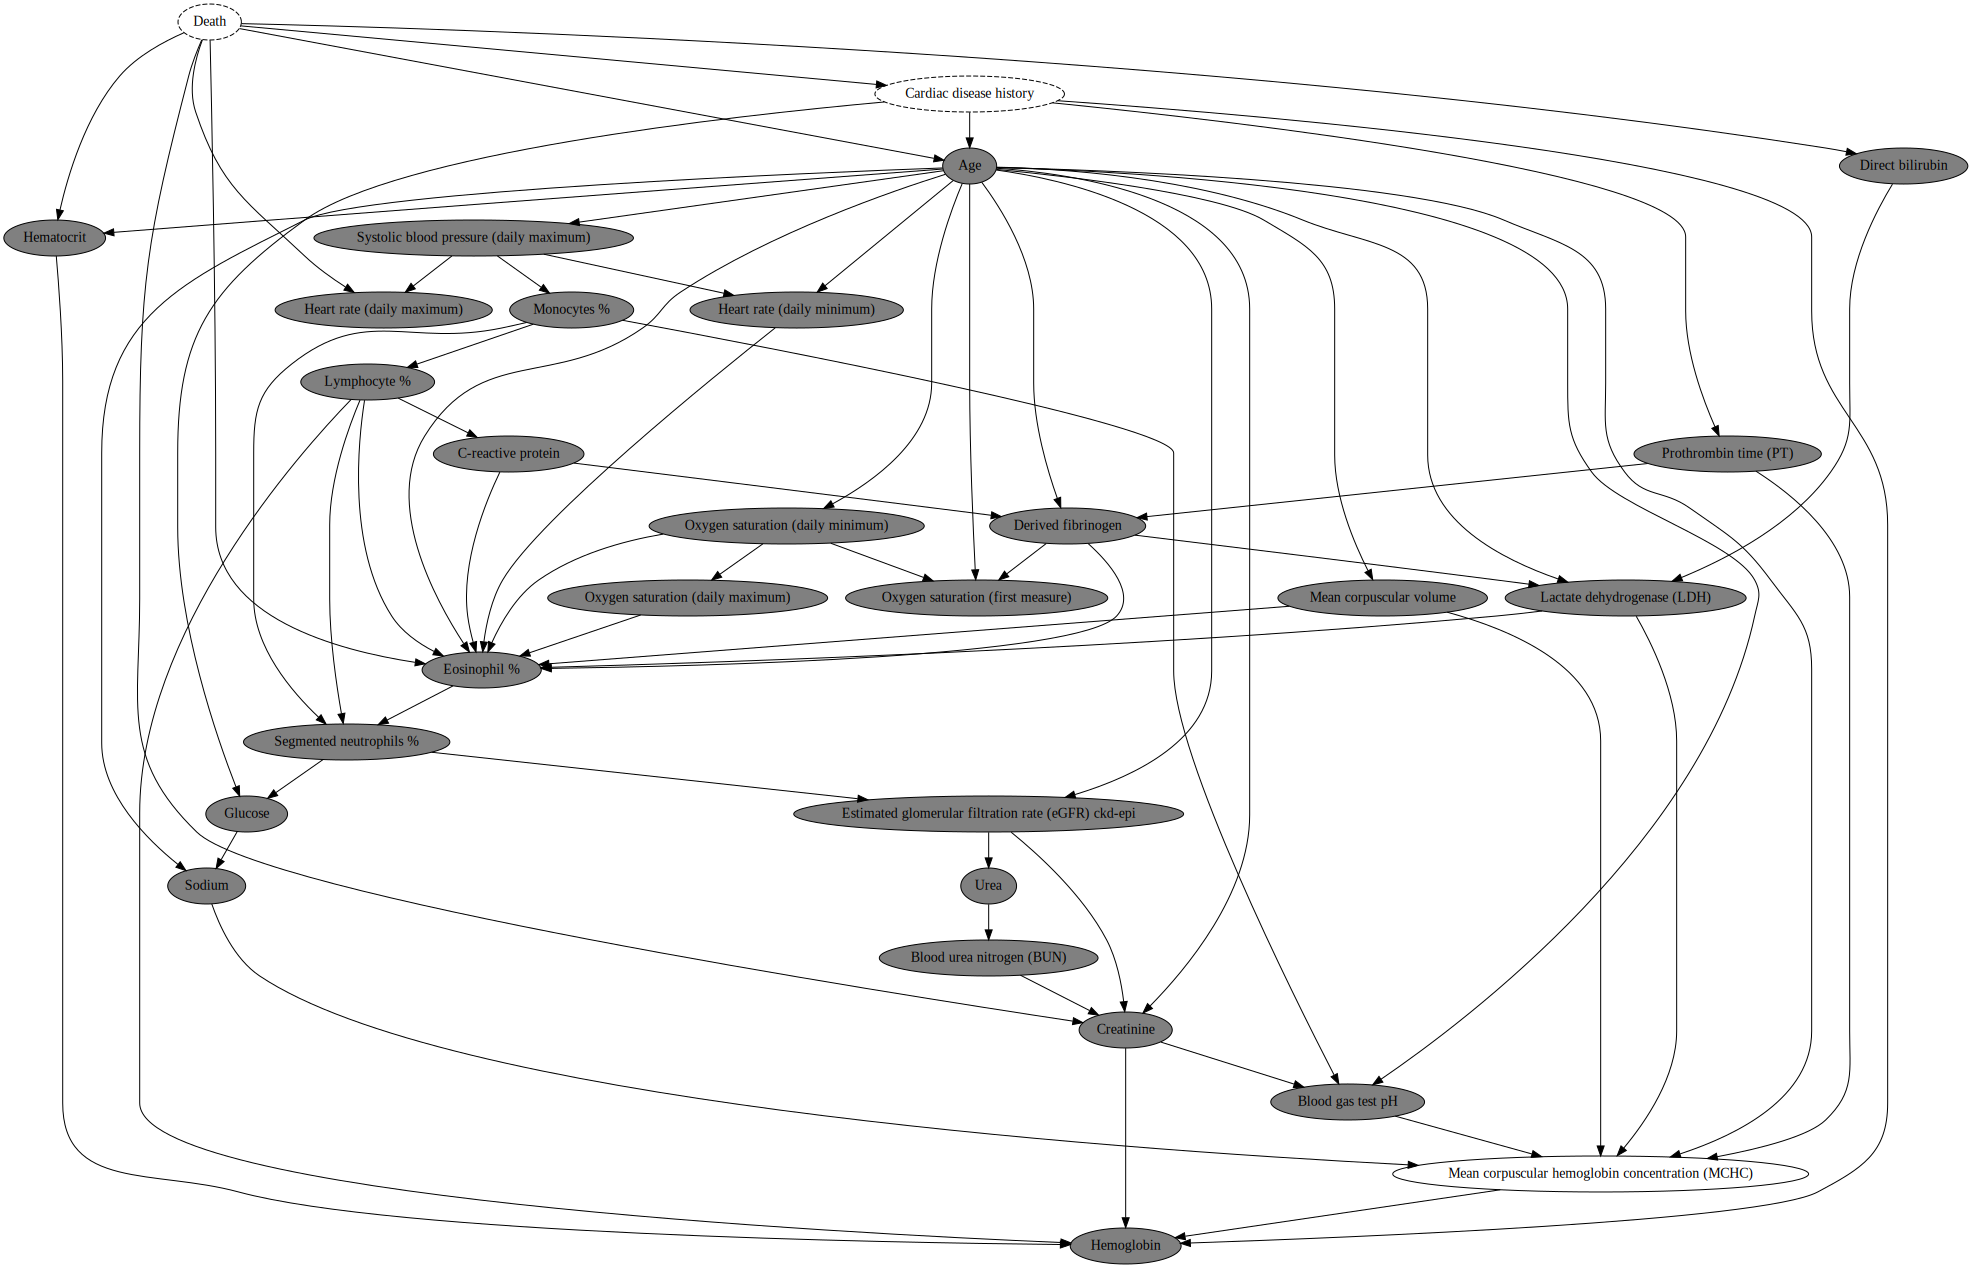

In [7]:
bn_unconstrained_sp = pybn.load('bn_unconstrained_sp.pickle')
view_pydot(draw_model(bn_unconstrained_sp))

### Validate models

In [8]:
t = Timer().tic()
val_pred_prob = complete_samples_prediction(bn_unconstrained_sp, df_omicron_test.copy(), CLASS, df_omicron_test[CLASS].dtype.categories)
t.toc()
print('Accuracy BN SP')
np.mean(val_pred_prob.idxmax(axis=1).values == df_omicron_test[CLASS].values)

Elapsed 0.3699831962585449s
Accuracy BN SP


0.8787878787878788

## Counterfactual algorithm

In [9]:
from pymoo.core.problem import Problem
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.termination import Termination
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.sampling import Sampling
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo import factory
from sklearn.preprocessing import LabelEncoder
from paretoset import paretoset
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import median_abs_deviation, boltzmann

class CEProblem(Problem):
    def __init__(self, eval_distance, eval_ce_prob, original_sample, encoder, is_feature, model, target_class, lik_f,
                 changeable_features=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.distance_f = eval_distance
        self.ce_prob_f = eval_ce_prob
        self.original_sample_raw = original_sample
        self.original_sample = encoder.encode(original_sample)[0]
        self.target = original_sample.columns[np.logical_not(is_feature)][0]
        self.encoder = encoder
        self.is_feature = is_feature
        self.changeable_features = changeable_features
        self.model = model
        self.target_class = encoder.encoders[np.where(np.logical_not(is_feature))[0][0]].transform([target_class])[0]
        self.target_class_raw = target_class
        self.lik_f = lik_f

    def _evaluate(self, x, out, *args, **kwargs):
        dec = self.encoder.decode(x)
        val_pred_prob = self.ce_prob_f(
            dec,
            self.target,
            dec[self.target].dtype.categories)
        dists, _ = self.distance_f(self.original_sample, x)
        #crowding = np.array([np.mean(distance(x[i, :], x)[1]) for i in range(x.shape[0])])
        out["F"] = np.column_stack([dists, -1* val_pred_prob[self.target_class_raw]])
        out["G"] = np.column_stack([self.lik_f(self.model, dec), np.max(val_pred_prob, axis=1) - val_pred_prob[self.target_class_raw]])


class MutateSampler(Sampling):
    def __init__(self, mutator):
        self.mutator = mutator

    def _do(self, problem, n_samples, **kwargs):
        ret = np.empty((n_samples, problem.n_var))
        ret[:] = problem.original_sample
        ret[:, np.where(np.logical_not(problem.is_feature))[0]] = problem.target_class
        return self.mutator._do(problem, ret, p_mut=1.0)


class SwapCrossover(Crossover):
    def _do(self, problem, X, **kwargs):
        swap_points = np.random.choice(X.shape[2], X.shape[1])
        r_l = X[1, np.arange(X.shape[1]), swap_points]
        l_r = X[0, np.arange(X.shape[1]), swap_points]
        X[0, np.arange(X.shape[1]), swap_points] = r_l
        X[1, np.arange(X.shape[1]), swap_points] = l_r
        return X


class CEMutate(Mutation):
    def __init__(self, sample_f, logl_f, default_p_mut=1.0, n_samples=100, n_changed=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_f = sample_f
        self.logl_f = logl_f
        self.n_samples = n_samples
        if n_changed is None:
            def generate_boltzmann():
                while True:
                    yield from boltzmann.rvs(lambda_=2, N=3, loc=1, size=1000)
            generator = generate_boltzmann()
            self.n_changed = lambda: next(generator)
        else: self.n_changed = n_changed 
        self.default_p_mut = default_p_mut

    def mutate_group(self, group, model, features):
        to_impute = np.random.choice(features, self.n_changed())
        imp = self.sample_f(model, group, to_impute, group.dtypes, n=self.n_samples, seed=np.random.randint(0, 2**31))
        return imp

    def _do(self, problem, X, p_mut=None, **kwargs):
        p_mut = self.default_p_mut if p_mut is None else p_mut
        mut_idxs = np.arange(X.shape[0])
        if p_mut < 1.0:
            mut_idxs = np.random.choice(mut_idxs, size=int(p_mut*X.shape[0]), replace=False)
        expanded = problem.encoder.decode(np.repeat(X[mut_idxs], self.n_samples, axis=0))
        features = problem.changeable_features
        if features is None:
            features = expanded.columns[problem.is_feature]
        mutated = expanded.groupby(expanded.index // self.n_samples).apply(
            self.mutate_group, model=problem.model, features=features)
        if self.n_samples > 1:
            mutated['_lik'] = np.exp(self.logl_f(problem.model, mutated)) ** 5
            X[mut_idxs] = problem.encoder.encode(
                mutated.groupby(expanded.index // self.n_samples).sample(n=1, weights='_lik').drop(['_lik'], axis=1)
            )
        else:
            X[mut_idxs] = problem.encoder.encode(mutated)
        return X


class MixedDistance(object):
    def __init__(self, df, is_categorical, is_feature, weights=None):
        self.cont_idx = np.where(np.logical_not(is_categorical) & is_feature)[0]
        self.cat_idx = np.where(is_categorical & is_feature)[0]
        cont_vals = df.values[:, self.cont_idx]
        self.cont_norm = median_abs_deviation(cont_vals, axis=0)
        if weights is None:
            self.weights = np.array([1 / df.shape[1]] * df.shape[1])
        else:
            self.weights = weights


    def __call__(self, x, y):
        if type(x) != np.ndarray or type(y) != np.ndarray:
            x, y = np.array(x), np.array(y)
        dist = np.zeros_like(y)
        if len(self.cont_idx) > 0:
            dist[:,self.cont_idx] = np.tanh((np.abs(
                x[self.cont_idx].astype(float) - y[:, self.cont_idx].astype(float)) / self.cont_norm.astype(float)))
        if len(self.cat_idx) > 0:
            dist[:,self.cat_idx] = (x[self.cat_idx] != y[:, self.cat_idx]).astype(float)
        return np.dot(dist, self.weights), dist


class Encoder(object):
    def __init__(self, df, is_categorical):
        self.is_categorical = is_categorical
        self.dtypes = df.dtypes
        self.columns = df.columns
        self.encoders = []
        for i, c in enumerate(is_categorical):
            if c:
                self.encoders.append(LabelEncoder().fit(df.iloc[:, i]))
            else:
                self.encoders.append(None)

    def encode(self, df):
        encoded = np.empty(df.shape, dtype=float)
        for i in range(encoded.shape[1]):
            if self.is_categorical[i]:
                encoded[:, i] = self.encoders[i].transform(df.iloc[:, i])
            else:
                encoded[:, i] = df.iloc[:, i]
        return encoded
    

    def decode(self, arr):
        df = pd.DataFrame(arr, columns=self.columns)
        cat_assign = {}
        dtype_assign = {}
        for i, c in enumerate(self.is_categorical):
            if c:
                cat_assign[self.columns[i]] = self.encoders[i].inverse_transform(
                    df.iloc[:,i].astype(int)
                )
            dtype_assign[self.columns[i]] = self.dtypes[i]

        return df.assign(**cat_assign).astype(dtype_assign)


class PlotCallback(Callback):

    def __init__(self, ref_point=[1,0], y_label='P(objective_class)', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hypervolumes = []
        self.hv_indicator = factory.get_performance_indicator('hv', ref_point=ref_point)
        self.y_label = y_label

    def notify(self, algorithm):
        objectives = algorithm.pop.get("F")
        cv = algorithm.pop.get("CV")
        return self.notify__(objectives, cv, algorithm.n_gen)

    def notify__(self, objectives, cv, n_gen):
        clear_output()
        objectives = objectives[:,:2]
        self.hypervolumes.append(self.hv_indicator._do(objectives))
        objectives = np.copy(objectives)
        objectives[:,1] = objectives[:, 1] * -1
        feasible_objectives = objectives[(cv == 0)[:,0]]
        unfeasible_objectives = objectives[(cv > 0)[:,0]]
        non_dominated_feasible = feasible_objectives[paretoset(feasible_objectives, sense=['min', 'max'])]
        dominated_feasible = feasible_objectives[np.logical_not(paretoset(feasible_objectives, sense=['min', 'max']))]

        plt.figure(figsize=(10, 7))
        plt.scatter(non_dominated_feasible[:,0], non_dominated_feasible[:,1], s=40, color='r', label='Non dominated')
        plt.scatter(dominated_feasible[:,0], dominated_feasible[:,1], s=10, facecolors='none', edgecolors='b', label='Dominated')
        plt.scatter(unfeasible_objectives[:,0], unfeasible_objectives[:,1], s=10, facecolors='k', edgecolors='g', label='Unfeasible')
        plt.xlabel('Distance to original', fontsize=12)
        plt.ylabel(self.y_label, fontsize=12)
        plt.ylim(bottom=0, top=1)
        plt.xlim(left=0, right=1)
        plt.title(f'Iteration {n_gen}, Hypervolume: {self.hypervolumes[-1]:.2f}', fontsize=12)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()


class RoundDifferenceRepair(Repair):
    def __init__(self, x_min, x_max, tol=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tol = tol
        self.x_min = x_min
        self.x_max = x_max

    def _do(self, problem, pop, **kwargs):
        Z = pop.get("X")
        _, dists_pairwise = problem.distance_f(problem.original_sample, Z)
        for i in range(Z.shape[1]):
            if not problem.is_feature[i]: continue
            where = dists_pairwise[:,i] < self.tol
            Z[where, i] = problem.original_sample[i]
        Z = np.clip(Z, self.x_min, self.x_max)
        pop.set("X", Z)
        return pop


class HVDeltaTermination(Termination):
    def __init__(self, min_increase=0.01, patience=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tol = min_increase
        self.patience = patience
        self._n_gens = 0
        self._last_best = 0
        self._curr_improv = 0
    
    def _do_continue(self, algorithm, **kwargs):
        hv = algorithm.callback.hypervolumes[-1]
        self._curr_improv = max(self._curr_improv, hv - self._last_best)
        if hv > self._last_best:
            self._last_best = hv
        self._n_gens += 1
        if self._curr_improv > self.tol:
            self._curr_improv = self._n_gens = 0
            return True
        elif self._n_gens > self.patience:
            return False
        else:
            return True

### Apply to Semiparametric Bayesian Network classifier

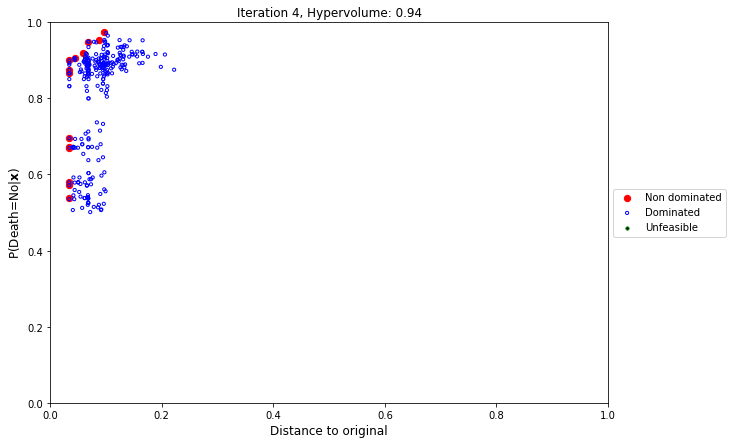

In [10]:
np.random.seed(SEED)
is_cat = df_omicron_train.dtypes.astype(str) == 'category'
encoder = Encoder(df_omicron_train, is_cat)
original_sample = df_omicron_train.iloc[[7]]
is_feature = df_omicron_train.columns != CLASS
changeable = [x for x in df_omicron_train.columns if x not in (CLASS, 'Age')]
distance = MixedDistance(df_omicron_train, is_cat, is_feature)
target = "N"
model = bn_unconstrained_sp
cond_logps = model.logl(df_omicron_train[df_omicron_train[CLASS]==target])
min_logp = np.mean(cond_logps) - np.std(cond_logps)

problem = CEProblem(
    distance, lambda *args: complete_samples_prediction(model, *args), original_sample, encoder, is_feature, model,
    target, lik_f=lambda model, samples: min_logp - model.logl(samples), changeable_features=changeable,
    n_var=original_sample.shape[1], n_constr=2, type_var=float)

cross = SwapCrossover(n_parents=2, n_offsprings=2)
mut = CEMutate(
    sample_f=forward_sampling,
    logl_f=lambda model, samples: model.logl(samples),
    default_p_mut=1.0,
    n_samples=1, n_changed=None)
sampler = MutateSampler(mut)
repair = RoundDifferenceRepair(
    tol=0.2, x_min=encoder.encode(df_omicron_train).min(axis=0), x_max=encoder.encode(df_omicron_train).max(axis=0))
algorithm = NSGA2(
    pop_size=300,
    termination=HVDeltaTermination(patience=1),
    sampling=sampler,
    mutation=mut,
    repair=repair,
    crossover=cross,
    eliminate_duplicates=False)
res = minimize(problem, algorithm, callback=PlotCallback(y_label=r'P(Death=No|$\bf{x}$)'), seed=SEED)

In [11]:
original = original_sample.copy()
target_verbose = ["No", "Yes"][target=="S"]
original.index = ['Original']
original[f'P(Death={target_verbose}|x)'] = complete_samples_prediction(
    model, original_sample, CLASS, df_omicron_train[CLASS].dtype.categories)[target].iloc[0]
original['Distance'] = pd.NA

changed = []
counterfactuals = encoder.decode(res.X)
for col in changeable:
    if not all(counterfactuals[col].values == original[col].values[0]):
        changed.append(col)
print(changed)

['Oxygen saturation (first measure)', 'Direct bilirubin', 'C-reactive protein', 'Lactate dehydrogenase (LDH)', 'Creatinine', 'Eosinophil %', 'Urea']


In [12]:
original.style.format(precision=3)

,Cardiac disease history,Hematocrit,Heart rate (daily minimum),Blood urea nitrogen (BUN),Oxygen saturation (first measure),Prothrombin time (PT),Direct bilirubin,Blood gas test pH,C-reactive protein,Lactate dehydrogenase (LDH),Segmented neutrophils %,Heart rate (daily maximum),Derived fibrinogen,Oxygen saturation (daily maximum),Mean corpuscular volume,Sodium,Monocytes %,Hemoglobin,Creatinine,Eosinophil %,Glucose,Lymphocyte %,Estimated glomerular filtration rate (eGFR) ckd-epi,Urea,Systolic blood pressure (daily maximum),Oxygen saturation (daily minimum),Age,Mean corpuscular hemoglobin concentration (MCHC),Death,P(Death=No|x),Distance
Original,Si,33.100,61.400,45.000,93.600,12.510,0.290,7.390,0.800,259.000,77.300,92.000,559.200,99.000,99.400,135.000,9.900,11.300,5.400,0.300,90.000,12.400,64.087,96.000,107.200,93.200,85.000,34.100,S,0.363,


In [13]:
def show_counterfactuals(res, changed, original, target_verbose):
    counterfactuals = encoder.decode(res.X)[changed + [CLASS]]
    counterfactuals['Distance'] = res.F[:,0]
    counterfactuals[f'P(Death={target_verbose}|x)'] = -1 * res.F[:,1]
    counterfactuals.sort_values(f'P(Death={target_verbose}|x)', inplace=True)
    counterfactuals.drop_duplicates(inplace=True, ignore_index=True)
    counterfactuals.drop(CLASS, axis=1, inplace=True)
    counterfactuals = pd.concat([original[counterfactuals.columns].reindex(['Original']), counterfactuals])
    style = counterfactuals.style
    for col in changed:
        if col != CLASS:
            def color(x, col):
                return "color: blue;" if x > original[col].iloc[0] else "color: red;" if  x < original[col].iloc[0] else None
            style = style.applymap(color, subset=col, col=col)
    return style.format(precision=3)
show_counterfactuals(res, changed, original, target_verbose)

,Oxygen saturation (first measure),Direct bilirubin,C-reactive protein,Lactate dehydrogenase (LDH),Creatinine,Eosinophil %,Urea,Distance,P(Death=No|x)
Original,93.600,0.290,0.800,259.000,5.400,0.300,96.000,nan,0.363
0,93.600,0.050,0.800,259.000,5.400,0.300,96.000,0.034,0.538
1,93.600,0.000,0.800,259.000,5.400,0.300,96.000,0.034,0.572
2,93.600,0.290,0.800,259.000,5.400,1.224,96.000,0.034,0.579
3,93.600,0.290,0.800,259.000,5.400,1.568,96.000,0.034,0.670
4,93.600,0.290,0.800,259.000,5.400,1.575,96.000,0.034,0.672
5,93.600,0.290,0.800,259.000,5.400,1.776,96.000,0.034,0.695
6,93.600,0.290,0.800,259.000,2.325,0.300,96.000,0.034,0.867
7,93.600,0.290,0.800,259.000,2.300,0.300,96.000,0.034,0.875
8,93.600,0.290,0.800,259.000,1.915,0.300,96.000,0.034,0.901


In [14]:
def plot_dist_plausibility(target, target_verbose, bins=25):
    cond_logps = bn_unconstrained_sp.logl(df_omicron_train[df_omicron_train[CLASS]==target])
    plt.figure(figsize=(10, 7))
    plt.hist(cond_logps, density=True, alpha=0.6, bins=bins)

    beta = np.mean(cond_logps) - 1 * np.std(cond_logps)
    print(beta)
    ticks = np.linspace(min(cond_logps), max(cond_logps), num = 8).tolist() + [np.mean(cond_logps) - 1 * np.std(cond_logps)]
    labels = ['{:.1f}'.format(t) for t in ticks]
    labels[-1] = r'$\beta$'
    plt.xticks(ticks, labels, fontsize=13)
    plt.yticks(fontsize=13)

    mu, std = norm.fit(cond_logps)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2, label=r'Gaussian approximation $\mathcal{N}(\mu,\sigma),\, \beta=\mu-\sigma$')
    plt.title(
        f"Distribution of log(P(" +
        r"$\bf{x}$" +
        f", Death)) for Omicron data with Death='{target_verbose}'")
    plt.legend()
    plt.show()

-77.04705734946373


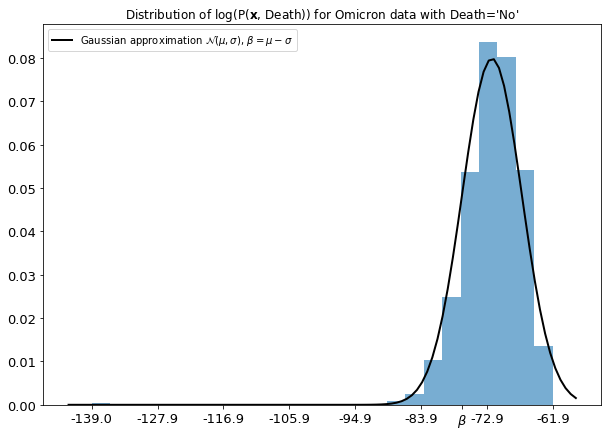

In [15]:
plot_dist_plausibility("N", "No")

-82.13246018843374


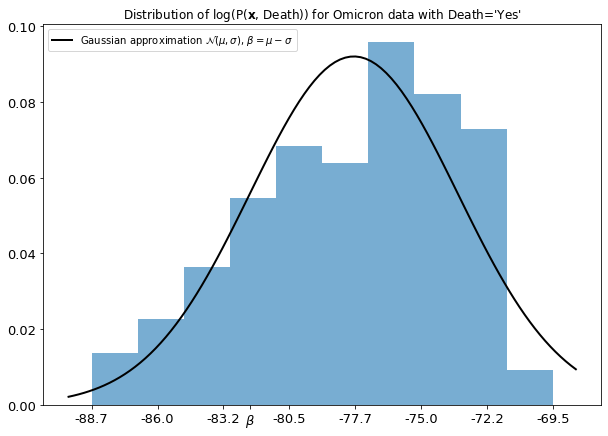

In [16]:
plot_dist_plausibility("S", "Yes", bins=10)